In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

In [2]:
# 企业信息
df1 = pd.read_excel('附件2：302家无信贷记录企业的相关数据.xlsx', sheetname = 0) 
df1['企业代号'] = df1['企业代号'].apply(lambda x: int(x[1:]))
df1.head()

,企业代号,企业名称
0,124,个体经营E124
1,125,个体经营E125
2,126,个体经营E126
3,127,个体经营E127
4,128,个体经营E128


In [3]:
# 进项发票信息
df2 = pd.read_excel('附件2：302家无信贷记录企业的相关数据.xlsx', sheetname = 2) 
df2['企业代号'] = df2['企业代号'].apply(lambda x: int(x[1:]))
df2.head()

,企业代号,发票号码,开票日期,销方单位代号,金额,税额,价税合计,发票状态
0,124,18891676,2017-09-01 00:00:00,C00014,338.46,57.54,396.0,有效发票
1,124,18691267,2017-09-01 00:00:00,C00480,230.10,6.90,237.0,有效发票
2,124,12995412,2017-09-01 00:00:00,C23675,223.30,6.70,230.0,有效发票
3,124,6378193,2017-09-01 11:11:03,C00333,90090.09,9909.91,100000.0,有效发票
4,124,6378194,2017-09-01 11:12:01,C00333,90090.09,9909.91,100000.0,有效发票


In [4]:
# 销项发票信息
df3 = pd.read_excel('附件2：302家无信贷记录企业的相关数据.xlsx', sheetname = 1)
df3['企业代号'] = df3['企业代号'].apply(lambda x: int(x[1:]))
df3.head()

,企业代号,发票号码,开票日期,购方单位代号,金额,税额,价税合计,发票状态
0,124,15212483,2017-09-01 11:58:43,D00585,839350.55,92328.56,931679.11,有效发票
1,124,15212484,2017-09-01 11:59:20,D00585,900900.90,99099.10,1000000.00,有效发票
2,124,15212485,2017-09-01 11:59:51,D00585,900900.90,99099.10,1000000.00,有效发票
3,124,15212486,2017-09-01 12:00:45,D00585,697365.74,76710.23,774075.97,有效发票
4,124,6089615,2017-09-05 10:58:38,D00108,726216.22,79883.78,806100.00,有效发票


In [5]:
# 删除作废发票
df2 = df2[df2['发票状态'] == '有效发票']
df3 = df3[df3['发票状态'] == '有效发票']

In [6]:
# 计算供应商数量
df_up = df2.groupby('企业代号')['销方单位代号'].unique()
df_up = df_up.apply(lambda x: len(x))
df_up = df_up.to_frame()
df_up.columns = ['供应商数量']

In [7]:
# 计算客户数量
df_down = df3.groupby('企业代号')['购方单位代号'].unique()
df_down = df_down.apply(lambda x: len(x))
df_down = df_down.to_frame()
df_down.columns = ['客户数量']

In [8]:
df1['供应商数量'] = df_up['供应商数量'].tolist()
df1['客户数量'] = df_down['客户数量'].tolist()

In [9]:
df2_amount = df2.groupby('企业代号')[['价税合计']].sum()
df3_amount = df3.groupby('企业代号')[['价税合计']].sum()
df1['现金流总量'] = list((df2_amount + df3_amount)['价税合计'])

In [10]:
df1.columns = ['id','name','X1','X2','X3']

In [11]:
import math

df1['lgX1'] = [math.log(s) for s in df1['X1']]
df1['lgX2'] = [math.log(s) for s in df1['X2']]
df1['lgX3'] = [math.log(s) for s in df1['X3']]
df1 = df1.drop(['X1', 'X2','X3'], axis=1)

In [12]:
%matplotlib inline
import os
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.max_columns', None) # 显示所有列
pd.set_option('display.max_rows', None) # 显示所有行

In [13]:
beta0 = 15.0535
beta1 = 0.7033
beta2 = -0.6596
beta3 = -1.0643
beta0_list = list(np.array([beta0]*302))
beta1_list = list(np.array([beta1]*302) * df1['lgX1'])
beta2_list = list(np.array([beta2]*302) * df1['lgX2'])
beta3_list = list(np.array([beta3]*302) * df1['lgX3'])
linear_value = [beta0_list[i]+beta1_list[i]+beta2_list[i]+beta3_list[i] for i in range(len(beta0_list))]
df1['pi'] = [math.exp(i)/(1+math.exp(i)) for i in linear_value]

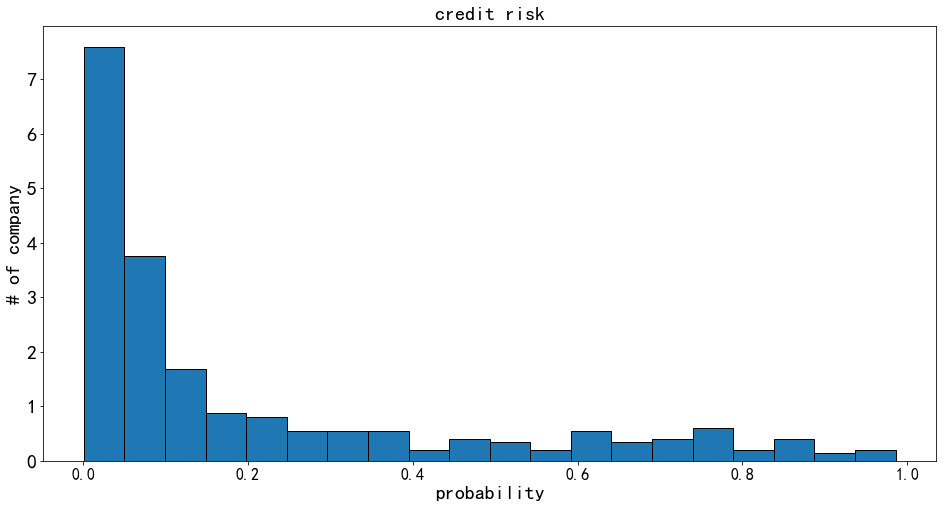

In [14]:
plt.figure(figsize = (16, 8))
plt.hist(list(df1['pi']), bins = 20, density = True, edgecolor = 'black')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 20)
plt.xlabel('probability', fontsize = 20)
plt.ylabel('# of company', fontsize = 20)
plt.savefig('distribution_of_pi_2.jpg')
plt.show()

In [15]:
# 计算信誉风险各评级的比例
a_num = 27
b_num = 38
c_num = 34
d_num = 24
total_num = a_num + b_num + c_num + d_num
percent_list = [a_num/total_num, b_num/total_num, c_num/total_num, d_num/total_num]
percent_list

[0.21951219512195122,
 0.3089430894308943,
 0.2764227642276423,
 0.1951219512195122]

In [16]:
df1['quantile'] = df1['pi'].rank() / len(df1['pi'])

In [17]:
threshold_value = [percent_list[0], percent_list[0] + percent_list[1], percent_list[0] + percent_list[1] + percent_list[2]]
threshold_value

[0.21951219512195122, 0.5284552845528455, 0.8048780487804879]

In [18]:
# 根据分位数阈值确定各企业的信誉评级
df1['rating'] = 0
for i in range(len(df1)):
    if df1['quantile'][i] < threshold_value[0]:
        df1['rating'][i] = 'A'
    elif df1['quantile'][i] < threshold_value[1]:
        df1['rating'][i] = 'B'
    elif df1['quantile'][i] < threshold_value[2]:
        df1['rating'][i] = 'C'
    else:
        df1['rating'][i] = 'D'

In [19]:
df1.head()

,id,name,lgX1,lgX2,lgX3,pi,quantile,rating
0,124,个体经营E124,7.246368,3.951244,21.225640,0.006389,0.086093,A
1,125,个体经营E125,7.489412,4.143135,21.429350,0.005382,0.072848,A
2,126,个体经营E126,4.276666,4.962845,20.318040,0.001072,0.003311,A
3,127,个体经营E127,5.693732,3.218876,20.327663,0.009013,0.109272,A
4,128,个体经营E128,6.276643,1.945910,19.376383,0.080325,0.483444,B


In [20]:
df1.to_excel('data2_quantile.xlsx')

下面通过R计算risk。

In [21]:
df_default_rate = pd.read_excel('附件3：银行贷款年利率与客户流失率关系的统计数据.xlsx', sheetname = 0)
df_default_rate.columns = ['贷款年利率','评级A的客户流失率','评级B的客户流失率','评级C的客户流失率']
df_default_rate = df_default_rate.drop([0]).reset_index().drop(columns=['index'])
df_default_rate.head()

,贷款年利率,评级A的客户流失率,评级B的客户流失率,评级C的客户流失率
0,0.0400,0,0,0
1,0.0425,0.0945741,0.0667996,0.0687253
2,0.0465,0.135727,0.135052,0.122099
3,0.0505,0.224603,0.20658,0.181252
4,0.0545,0.302038,0.276812,0.263303


In [22]:
df1 = pd.read_excel('data2_risk.xlsx', sheetname = 0)

In [23]:
df1.head()

,id,name,lgX1,lgX2,lgX3,pi,quantile,rating,risk
0,124,个体经营E124,7.246368,3.951244,21.225640,0.006389,0.086093,A,0.001756
1,125,个体经营E125,7.489412,4.143135,21.429350,0.005382,0.072848,A,0.001475
2,126,个体经营E126,4.276666,4.962845,20.318040,0.001072,0.003311,A,0.000065
3,127,个体经营E127,5.693732,3.218876,20.327663,0.009013,0.109272,A,0.002256
4,128,个体经营E128,6.276643,1.945910,19.376383,0.080325,0.483444,B,0.012881


In [24]:
w = 0.0175
result = np.zeros((len(df1), len(df_default_rate)))
R = [0 for i in range(len(df1))]

for i in range(len(df1)):
    for j in range(len(df_default_rate)):
        if df1['rating'][i] == 'A':        
            result[i,j] = (df_default_rate['贷款年利率'][j] - w - df1['risk'][i])*(1-df_default_rate['评级A的客户流失率'][j])
            R[i] = df_default_rate['贷款年利率'][np.argmax(np.array(list(result[i,:])))]
        elif df1['rating'][i] == 'B':
            result[i,j] = (df_default_rate['贷款年利率'][j] - w - df1['risk'][i])*(1-df_default_rate['评级B的客户流失率'][j])
            R[i] = df_default_rate['贷款年利率'][np.argmax(np.array(list(result[i,:])))]
        elif df1['rating'][i] == 'C':
            result[i,j] = (df_default_rate['贷款年利率'][j] - w - df1['risk'][i])*(1-df_default_rate['评级C的客户流失率'][j])
            R[i] = df_default_rate['贷款年利率'][np.argmax(np.array(list(result[i,:])))]
        else:
            result[i, :] = 0

df1['R'] = R

In [25]:
df1.groupby(['rating','R'])[['R']].count()

R
rating R         
A      0.0745  66
B      0.0825  93
C      0.0905  60
       0.1105  24
D      0.0000  59

In [26]:
df1.groupby(['rating'])[['R']].describe()

R                                                                
       count      mean           std     min     25%     50%     75%     max
rating                                                                      
A       66.0  0.074500  8.390480e-17  0.0745  0.0745  0.0745  0.0745  0.0745
B       93.0  0.082500  1.953421e-16  0.0825  0.0825  0.0825  0.0825  0.0825
C       84.0  0.096214  9.089344e-03  0.0905  0.0905  0.0905  0.1105  0.1105
D       59.0  0.000000  0.000000e+00  0.0000  0.0000  0.0000  0.0000  0.0000

In [27]:
df1.to_excel('data2_rate.xlsx')